Each project group will submit a single jupyter notebook which contains:

- (3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data
- (2%) A discussion of the preliminary results:

This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis

It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

# Preliminaries #

### Data loading and cleaning: ###

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [75]:
# load data
data = pd.read_csv('lichess_games_data.csv')
data.dropna(inplace=True)

In [76]:
# clean up the opening column so it only includes the broad category of opening (not variations)
data['opening_name'] = df['opening'].str.split(":").str[0].str.strip()

In [77]:
# drop original opening column
data = data.drop(columns = ['opening'])

In [78]:
# preliminary exploration of the data: 

print(f"The shape of the data is: {data.shape}")

data.head()

The shape of the data is: (163145, 9)


,game_id,white,white_rating,black,black_rating,winner,moves,link,opening_name
0,hN05at52,aapp_61,1678.0,zwenna,2442.0,black,54,https://lichess.org/hN05at52,Sicilian Defense
1,ttu4bd63,zwenna,2437.0,Aidas08,2136.0,white,77,https://lichess.org/ttu4bd63,Sicilian Defense
2,Qwoly8kd,Ugjgjgjvj,2058.0,zwenna,2434.0,black,44,https://lichess.org/Qwoly8kd,Italian Game
3,eMJwQKDV,zwenna,2433.0,Narcisse29,1820.0,white,21,https://lichess.org/eMJwQKDV,French Defense
4,8AFBBfka,zwenna,2433.0,Bracho2013,1089.0,white,57,https://lichess.org/8AFBBfka,Ruy Lopez


### Helper function construction: ###

In [79]:
# helper functions to translate the string "winner" feature (eg white, black, draw) into floats (eg 1, 0, 0.5)
def encode_winner(player_color, winner):
    if winner == player_color:
        return 1
    elif winner == 'draw':
        return 0.5
    return 0

def encode_winner_simple(winner):
    if winner == 'white':
        return 1
    if winner == 'black':
        return 0
    return 0.5

# helper function to add a bias column (for OLS) to an array of X features
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d  with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

# helper function to calculate the coefficients for the line of best fit given arrays of dependent and independent variables
def line_of_best_fit(X, y):
    """ calculates the coefficients for the line of best fit for a set of data
    Args:
        X (array): can be either 1-d or 2-d
        y (array): 1-d array including all corresponding response values to X
        
    Returns:
        m (vector): contains coefficients for line of best fit 
    """
    #add the bias column to X
    Xnew = add_bias_column(X)
    
    # Inverse of Xnew.transpose * Xnew
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # Xnew.transpose * y 
    Xty = np.matmul(Xnew.T, y)
    
    # [(XtX)^-1]Xty to get the vector w/ coefficients for line of best fit
    # m = [intercept, slope]
    m = np.matmul(XtXinv, Xty)
    return m

# helper function to calculate the results of a linear regression model--eg y predictions, residuals, MSE, and R^2
def linreg_predict(Xnew, ynew, m):
    """ calculates the predicted y values using the coefficients of the line of best fit for the data.
    calculates the residuals, mse, and r^2 between the predicted and actual y values.
    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (vector): a 1-d array of length p+1 which contains the coefficients from the line_of_best_fit function
        
    Returns:
        linreg_dict (dictionary): dictionary containing key value pairs: ypreds, resids, mse, r2
    """
    Xnew = add_bias_column(Xnew)
    
    #calculating the predicted y values using the coefficients from line_of_best_fit
    ypreds = np.matmul(Xnew, m)

    #calculating residuals
    resids = ynew - ypreds

    #calculating mean square error (mse)
    sum_resids = 0
    for item in resids:
        sum_resids += item**2  
    mse = sum_resids/len(resids)

    #calculating r^2 value
    r2 = r2_score(ynew, ypreds)
    
    # Creating dictionary
    linreg_dict = {'ypreds' : ypreds,
                   'resids' : resids,
                   'mse' : mse,
                   'r2' : r2}
    return linreg_dict

# First Regression Model #

Our two primary areas of interest for the project are trying to predict the outcome of a game (eg whether white or black will win) and to predict how many moves it will take for the game to be completed. We decided to start with trying to model the winner of the game. Our first idea was to create a linear regression model that would use the rating differential between the two players playing the game (eg the white player's Lichess rating less the black player's Lichess rating) to predict the win outcome of the game. However, since win outcome is a categorical variable and linear regression is primarily useful to predict numerical features, we workshopped a different approach. 

We thought that one way to get an idea of a prediction would be to predict the win rate (rather than the win outcome) for a player based on the rating differential. We decided to bin the data by rating differential, so if the rating differential between two players in a game fell into the bucket of, for instance, 225 (eg perhaps white had a rating of 2225 and black had a rating of 2000) it would fall into the 200-250 bucket. We then calculated the win rate for white for each bucket. For example, in the 200-250 bucket, the white player wins about 77% of the time. This data manipulation yielded a new dataframe with about 40 observations (rating differential bins) that each had a given win rate. We then proceeded to fit a linear regression model to the new data, predicting win rate based on median rating differential. 

### Step 1: data manipulation ###

In [80]:
# prep data simply
white_data = data.copy()
white_data['player_rating'] = white_data['white_rating']
white_data['opponent_rating'] = white_data['black_rating']
white_data['win_outcome'] = white_data.apply(lambda row: encode_winner('white', row['winner']), axis=1)
black_data = data.copy()
black_data['player_rating'] = black_data['black_rating']
black_data['opponent_rating'] = black_data['white_rating']
black_data['win_outcome'] = black_data.apply(lambda row: encode_winner('black', row['winner']), axis=1)

#combine+ filter draws
combined_data = pd.concat([white_data, black_data])
combined_data = combined_data[combined_data['win_outcome'] != 0.5]

# bin ratings and group
bins = np.arange(800, 2800, 100)
labels = bins[:-1] + 50
combined_data['player_rating_bin'] = pd.cut(combined_data['player_rating'], bins, labels=labels)
combined_data['opponent_rating_bin'] = pd.cut(combined_data['opponent_rating'], bins, labels=labels)

# pivot for the win percentages
win_table = combined_data.pivot_table('win_outcome', index='player_rating_bin', columns='opponent_rating_bin', aggfunc='mean', observed = False) * 100

# adding rating differential and win outcome as columns to the original dataframe (for use later as needed)
data['rating_diff'] = data['white_rating'] - data['black_rating']
data['win_outcome'] = data['winner'].apply(encode_winner_simple)

# win % grouped by diff bins
bins = np.arange(-1000, 1000, 50)
data['rating_diff_bin'] = pd.cut(data['rating_diff'], bins)
win_percentage = data.groupby('rating_diff_bin', observed=True)['win_outcome'].mean().reset_index()

# midpoints (grouping the categories of ratings)
win_percentage['rating_diff_mid'] = win_percentage['rating_diff_bin'].apply(lambda x: x.mid)

In [81]:
# prints the win rate/rating differential dataframe for examination
win_percentage

,rating_diff_bin,win_outcome,rating_diff_mid
0,"(-1000, -950]",0.129518,-975.0
1,"(-950, -900]",0.116071,-925.0
2,"(-900, -850]",0.098826,-875.0
3,"(-850, -800]",0.102024,-825.0
4,"(-800, -750]",0.152113,-775.0
5,"(-750, -700]",0.127273,-725.0
6,"(-700, -650]",0.125668,-675.0
7,"(-650, -600]",0.136850,-625.0
8,"(-600, -550]",0.217405,-575.0
9,"(-550, -500]",0.183839,-525.0


### Step 2: Implement the linear regression programmatically using maths/Numpy ###

In [88]:
X = win_percentage['rating_diff_mid'].values
y = win_percentage['win_outcome'].values
X_b = np.c_[np.ones((len(X), 1)), X]
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
y_pred = X_b @ theta_best

### Step 3: Build some visualizations to explore the initial data (heatmap) and see how the regression model looks (scatter/line plot) ###

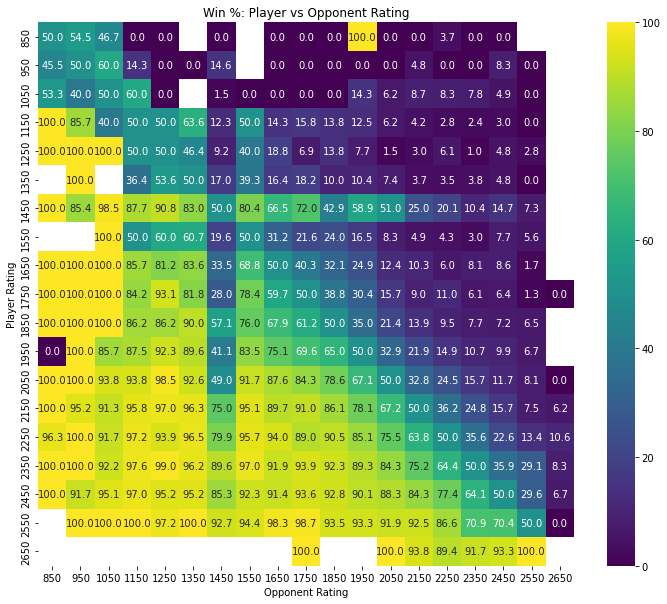

In [89]:
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(win_table, annot=True, fmt=".1f", cmap='viridis')
plt.title('Win %: Player vs Opponent Rating')
plt.xlabel('Opponent Rating')
plt.ylabel('Player Rating')
plt.show()

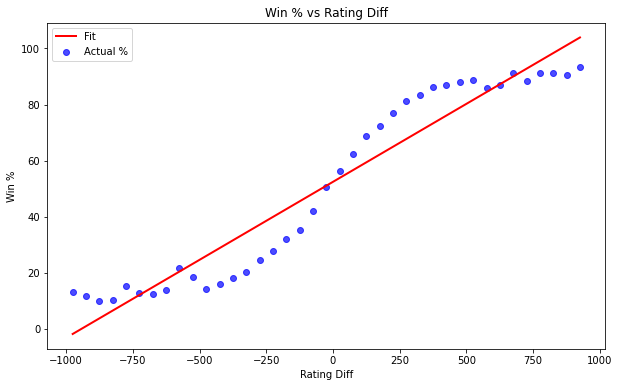

In [90]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(X, y * 100, color='blue', alpha=0.7, label='Actual %')  # data points
plt.plot(X, y_pred * 100, color='red', linewidth=2, label='Fit')  #our regression line
plt.title('Win % vs Rating Diff')
plt.xlabel('Rating Diff')
plt.ylabel('Win %')
plt.legend()
plt.show()

#### Discussion: ####
It is clear from the initial visualization that there is indeed a pattern to the data. There is significant curvature to the dots that represent each rating differential point and its associated win rate. The line of best fit seems to travel fairly accurately through the middle-ish points of the curved line created by the scatter points. However, this shape suggests that perhaps a linear regression model is not the best way to make predictions on this data, but we will persist and calculate the results of the initial model anyway. 

### Step 4: Calculate the results of the full dataset model ###

In [93]:
linreg_dict = linreg_predict(X,y,theta_best)
resids = linreg_dict['resids']
mse = linreg_dict['mse']
r2 = linreg_dict['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 0.008153554912551328
R^2: 0.923279666609376


#### Discussion: #### 
The R^2 score is very good here, suggesting that the rating differential can explain approximately 92% of the variation in the win rate for the white player. This suggests that the model is strong, with robust predictive power, despite the fact that the shape suggests the pattern is not linear. 

### Step 5: Single-fold 70/30 cross-validated results ###

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state = 3)

#calculating coefficients for line of best fit
m = line_of_best_fit(X_train, y_train)

#running predictions and calculating MSE and R^2
linreg_dict = linreg_predict(X_test, y_test, m)
mse = linreg_dict["mse"]
r2 = linreg_dict['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 0.010595315600734302
R^2: 0.8822509664418586


#### Discussion: ####
The model's performance remains exceptional on a cross-validated basis. MSE rose slightly and R^2 declined slightly, but the R^2 value remains at just under 0.9, suggesting that the model has strong predictive power. 

### Step 6: Create residual plots to test assumptions ###

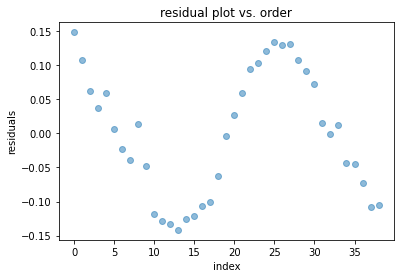

In [10]:
# residuals versus order (ordered e plot)
plt.scatter(range(len(X_b)), resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

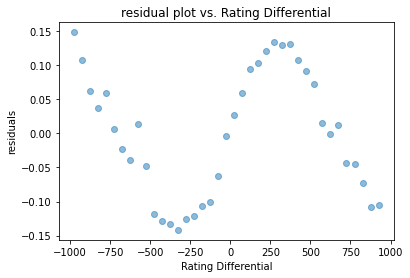

In [11]:
#residual plot vs x feature (rating diff)
plt.scatter(X, resids, alpha=0.5)
plt.xlabel("Rating Differential")
plt.ylabel("residuals")
plt.title("residual plot vs. Rating Differential")
plt.show()

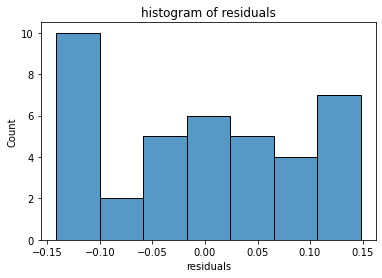

In [12]:
# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Step 7: Discussion and reflections ###

Residual plots of the linear regression suggest we may need to look at trinomial or another variable since there are clear patterns. The residual plot as a function of the index shows an oscillating pattern indicating autocorrelation. The residual plot as a function of rating differential also shows the oscillating pattern indicating a non-linear dataset and heteroscedasticity. A normal distribution of the residuals is not present. Polynomial regression at the 3rd degree was implemented to potentiall address the issues

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6, include_bias = False)
X_poly = poly.fit_transform(np.array(X).reshape(-1,1))

In [14]:
#fitting model to full dataset

#calculating coefficients to line of best fit
m_full = line_of_best_fit(X_poly, y)

#running predictions
linreg_dict = linreg_predict(X_poly, y, m_full)

mse = linreg_dict["mse"]
r2 = linreg_dict['r2']
resids = linreg_dict['resids']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 0.0005733397223464467
R^2: 0.9946051979637992


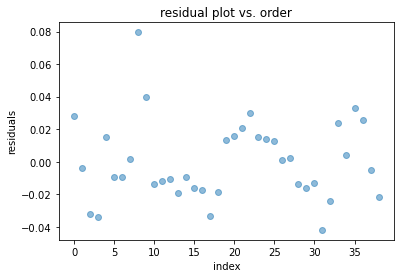

In [15]:
# residuals versus order
plt.scatter(range(len(X_poly)), resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. order")
plt.show()

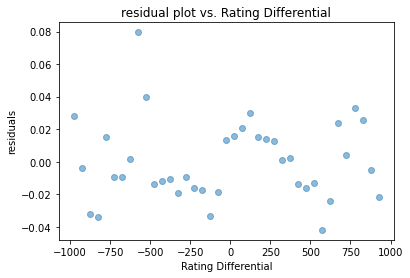

In [16]:
#residual plot vs Rating Diff
plt.scatter(X, resids, alpha=0.5)
plt.xlabel("Rating Differential")
plt.ylabel("residuals")
plt.title("residual plot vs. Rating Differential")
plt.show()

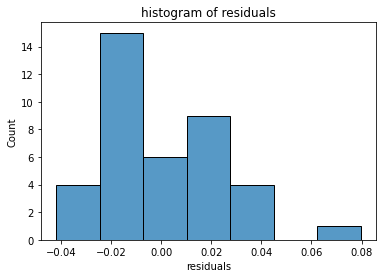

In [17]:
# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

### Discussion
A trinomial linear regression did not address the issues observed in the regression plots for the monomial linear regression. A multiple regression will likely be the next step.

In [61]:
df = data.copy()

# build a column with the opening name and first variation
df['opening_name'] = df['opening'].str.split(":").str[0].str.strip()

df.head()

,game_id,white,white_rating,black,black_rating,opening,winner,moves,link,opening_name
0,hN05at52,aapp_61,1678.0,zwenna,2442.0,Sicilian Defense: Bowdler Attack,black,54,https://lichess.org/hN05at52,Sicilian Defense
1,ttu4bd63,zwenna,2437.0,Aidas08,2136.0,"Sicilian Defense: Najdorf Variation, Zagreb Va...",white,77,https://lichess.org/ttu4bd63,Sicilian Defense
2,Qwoly8kd,Ugjgjgjvj,2058.0,zwenna,2434.0,"Italian Game: Two Knights Defense, Modern Bish...",black,44,https://lichess.org/Qwoly8kd,Italian Game
3,eMJwQKDV,zwenna,2433.0,Narcisse29,1820.0,"French Defense: Tarrasch Variation, Pawn Cente...",white,21,https://lichess.org/eMJwQKDV,French Defense
4,8AFBBfka,zwenna,2433.0,Bracho2013,1089.0,Ruy Lopez: Berlin Defense,white,57,https://lichess.org/8AFBBfka,Ruy Lopez


In [21]:
df = pd.get_dummies(df, columns = ['opening_name'], drop_first = True)

In [22]:
df = df.dropna()

In [23]:
# standardize the black ratings and white ratings
for feat in ['white_rating', 'black_rating']:
    df[f'{feat}_scaled'] = (df[feat] - df[feat].mean()) / df[feat].std()
    
reg_df = df.drop(columns = ['game_id', 'white', 'white_rating', 'black', 'black_rating', 'opening', 'winner', 'link', 'rating_diff', 'rating_diff_bin', 'moves'], axis = 1)

reg_df['rating_interaction'] = reg_df.white_rating_scaled * reg_df.black_rating_scaled

In [25]:
# build the X and y arrays using the scaled x values and the y values
X = reg_df.values
y = df['moves'].values

In [26]:
fitted_model = line_of_best_fit(X, y)

linreg_dict = linreg_predict(X,y,fitted_model)

fitted_model

resids = linreg_dict['resids']
mse = linreg_dict['mse']
r2 = linreg_dict['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 1250.2917217882698
R^2: 0.0677737975509336


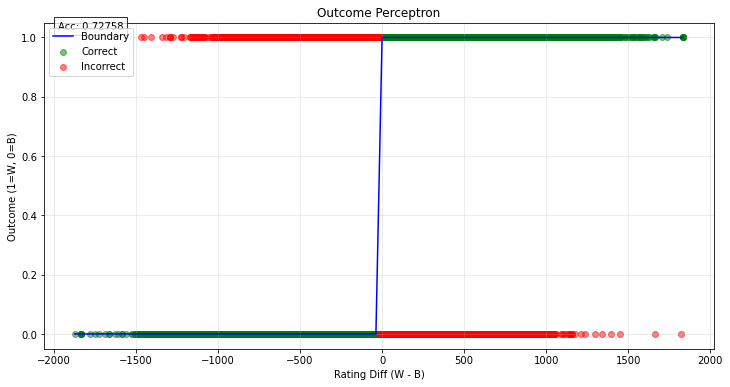

In [27]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Filter only the clear winners.
clear_games = data[data['win_outcome'] != 0.5].copy()

# input/output for perceptron
X_perc = clear_games['rating_diff'].values.reshape(-1, 1)
y_perc = (clear_games['win_outcome'] == 1).astype(int)  # white win = 1, black = 0

clf = Perceptron(random_state=42)  # train model
clf.fit(X_perc, y_perc)

# boundary points for visual
X_boundary = np.linspace(X_perc.min(), X_perc.max(), 100).reshape(-1, 1)
y_boundary = clf.predict(X_boundary)  

y_pred = clf.predict(X_perc)  # preds for data
misclassified = y_pred != y_perc  # misclassify info

# scatter points
plt.figure(figsize=(12, 6))
plt.scatter(X_perc[~misclassified], y_perc[~misclassified], c='green', alpha=0.5, label='Correct')  # correct
plt.scatter(X_perc[misclassified], y_perc[misclassified], c='red', alpha=0.5, label='Incorrect')  # wrong

plt.plot(X_boundary, y_boundary, 'b-', label='Boundary')  # decision line
plt.title('Outcome Perceptron')
plt.xlabel('Rating Diff (W - B)')
plt.ylabel('Outcome (1=W, 0=B)')
plt.legend()
plt.grid(True, alpha=0.3)

accuracy = accuracy_score(y_perc, y_pred)  # model acc
plt.text(0.02, 0.98, f'Acc: {accuracy:.5f}', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()
